# Turbine Characteristics Modelling

> Date:

> Author: Elias Aoubala 

In [1]:
from turborocket.transient.start_up import Pump, Turbine, GasGenerator
from turborocket.characteristic.turbo_characteristic import TurboCharacteristics
from turborocket.fluids.fluids import IncompressibleFluid
import numpy as np
import handcalcs.render
import CoolProp.CoolProp as CP

import matplotlib.pyplot as plt

## 1 - Background

This document includes the relevant test cases to confirm that turbine modelling is meeting realistic expectations, as indicated by literature.

## 2 - Litterature

[First Paper](https://ntrs.nasa.gov/api/citations/19720005134/downloads/19720005134.pdf)

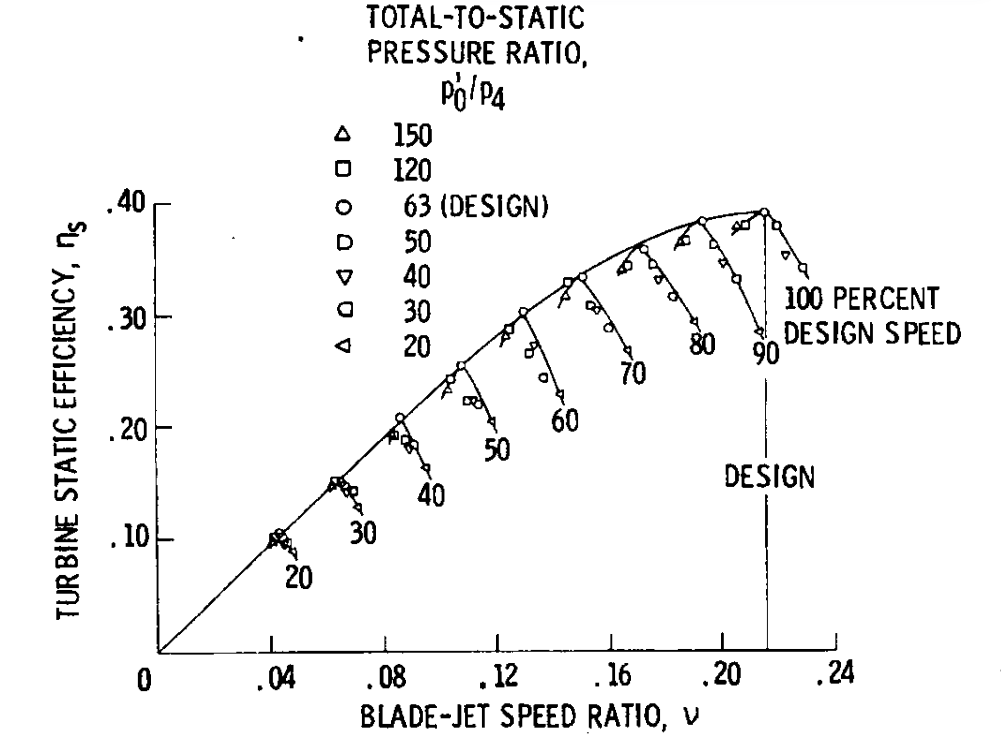

[Second Paper](https://ntrs.nasa.gov/api/citations/20030062761/downloads/20030062761.pdf)

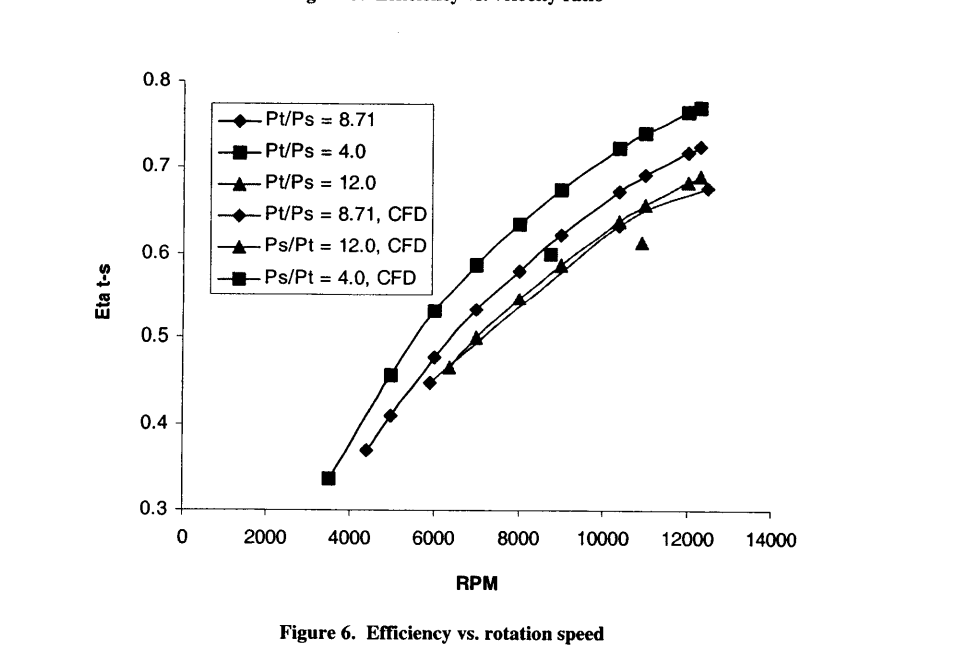



## 3 - Turbine Characteristics Plots

Here, we can demonstrate what the turbine characteristics look like from our model

In [2]:
import handcalcs.render
from rocketcea.cea_obj_w_units import CEA_Obj
import numpy as np
import matplotlib.pyplot as plt
from turborocket.transient.start_up import (
    GasGenerator,
    Pump,
    Turbine,
    LiquidValve,
    Cavity,
)
from turborocket.fluids.fluids import IncompressibleFluid, IdealGas

In [3]:
turbine = Turbine(a_rat=4.11, D_m=0.147, eta_nom=0.2, u_co_nom=0.13)

For this characteristic, we follow a similar procedure to that presented in the papers, where we do 10 different pressure ratios at 5 different speeds.

In [4]:
k1 = 5
k2 = 10

N = np.linspace(1e3, 25e3, k1)*(2*np.pi)/60

p_rat = np.linspace(50, 10, k2)

N, p_rat = np.meshgrid(N, p_rat)

combustion = IdealGas(p=1e5, t=800, gamma=1.2, R=800, cp=1200)

turbine_eta = np.zeros([k2, k1])

u_co = np.zeros([k2, k1])

for index, x in np.ndenumerate(N):

    combustion.set_pressure(p = p_rat[index]*1e5)

    # We need to get the velocity of the gas
    c_o = combustion.get_cis(p1 = 1e5)

    # We need to get the blade speed
    u = turbine.get_mean_speed(N = N[index])

    u_co[index] = u / c_o


    turbine_eta[index] = turbine.get_efficiency(combustion_gas = combustion, N = N[index], p_exit = 1e5)

We can also create a plot for the optimal line

In [5]:
k1 = 20

N_id = np.linspace(1e3, 25e3, k1) * (2 * np.pi) / 60

p_rat_id = [25]

p_rat_id, N_id = np.meshgrid(p_rat_id, N_id)

combustion = IdealGas(p=1e5, t=800, gamma=1.2, R=800, cp=1200)

turbine_eta_id = np.zeros([k1, 1])

u_co_id = np.zeros([k1, 1])

for index, x in np.ndenumerate(N_id):

    combustion.set_pressure(p=p_rat_id[index] * 1e5)

    # We need to get the velocity of the gas
    c_o = combustion.get_cis(p1=1e5)

    # We need to get the blade speed
    u = turbine.get_mean_speed(N=N_id[index])

    u_co_id[index] = u / c_o

    turbine_eta_id[index] = turbine.get_efficiency(
        combustion_gas=combustion, N=N_id[index], p_exit=1e5
    )

Text(0, 0.5, '$\\eta$')

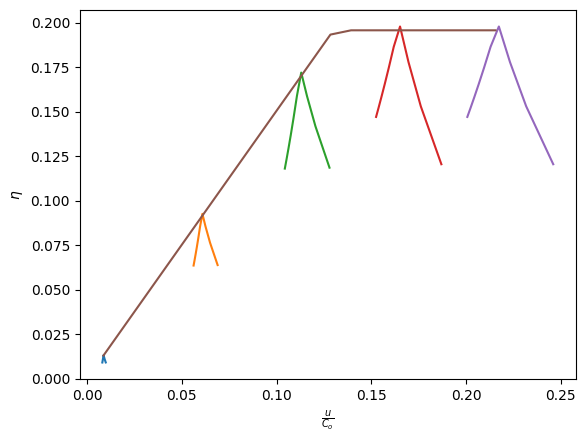

In [6]:
k = plt.plot(u_co, turbine_eta)
plt.plot(u_co_id, turbine_eta_id)

plt.xlabel(r"$\frac{u}{C_o}$")
plt.ylabel(r"$\eta$")

## 4 - Pump Characteristics Plots

In [7]:
import handcalcs.render
from rocketcea.cea_obj_w_units import CEA_Obj
import numpy as np
import matplotlib.pyplot as plt
from turborocket.transient.start_up import (
    GasGenerator,
    Pump,
    Turbine,
    LiquidValve,
    Cavity,
)
from turborocket.fluids.fluids import IncompressibleFluid

Text(0.5, 0, 'Mass Flow (n.d)')

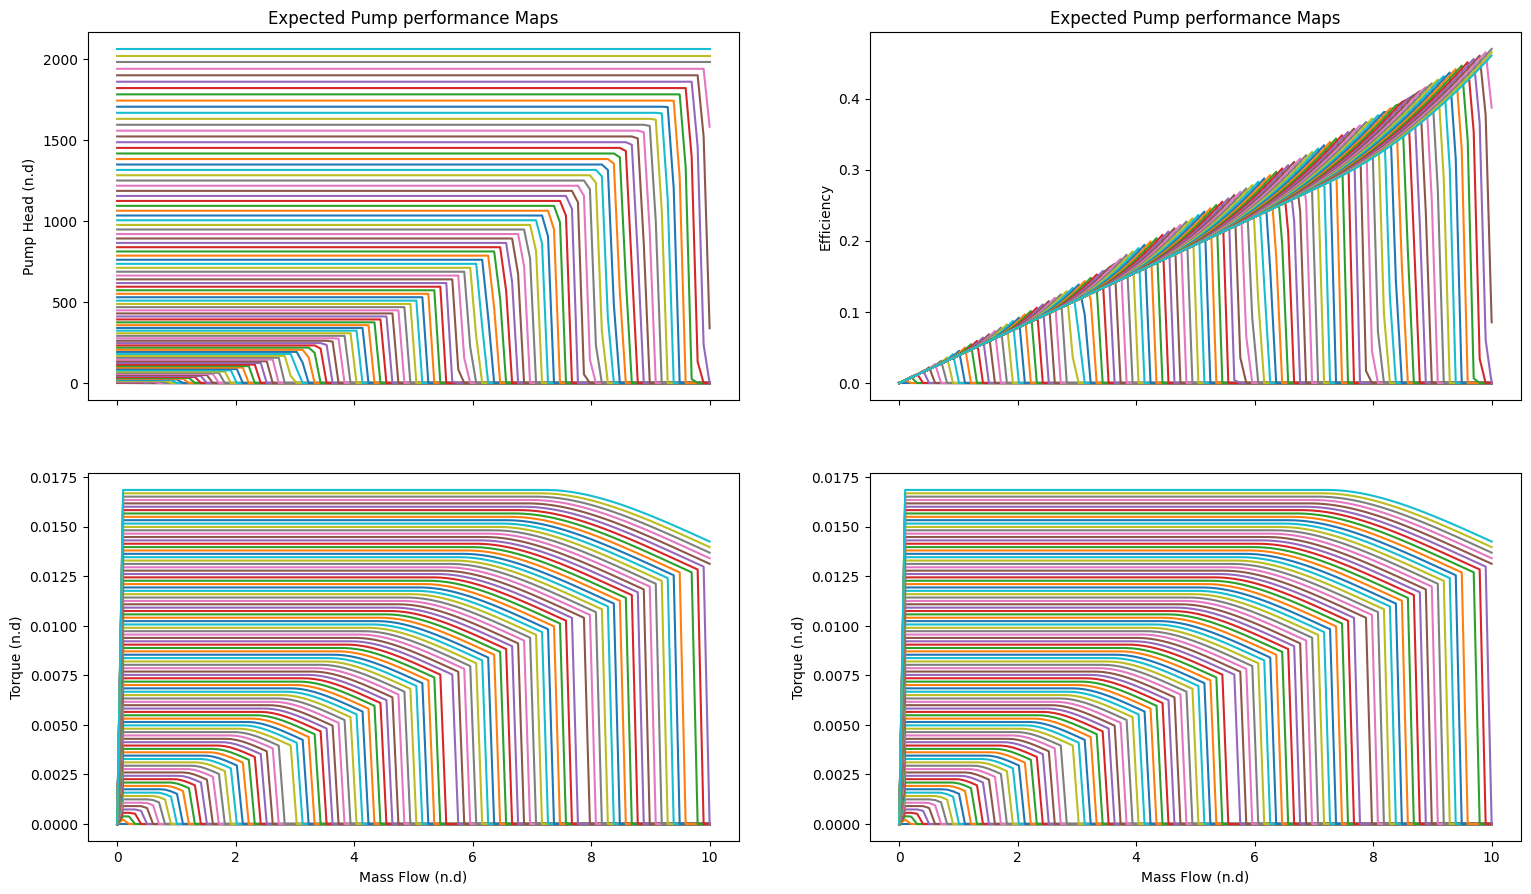

In [8]:
pump = Pump(D_1 = 3e-2,
            D_2 = 5e-2,
            D_3 = 8e-2)

pump.set_performance(C_c=0.95, psi=0.2, eta_bep=0.4, N_nom=25e3 * (2 * np.pi) / 60)

inlet = IncompressibleFluid(rho=1000, P=30e5, mue=2.86e-3)
k1 = 100
k2 = 100

N = np.linspace(100, 30e3, k1)*(2*np.pi)/60


m_dot = np.linspace(0, 10, k2)

N, m_dot = np.meshgrid(N, m_dot)


dp = np.zeros([k2, k1])
torque = np.zeros([k2, k1])
eta = np.zeros([k2, k1])


i = 0
for Ne in N:

    j = 0
    for m in m_dot[i,:]:
        m = m_dot[i,j]
        ne = N[i, j]

        dp[i, j] = (
            pump.get_exit_condition(inlet=inlet, N=ne, m_dot=m).get_pressure()
            - inlet.get_pressure()
        )

        torque[i, j] = pump.get_torque(inlet=inlet, N=ne, m_dot=m)

        eta[i, j] = pump.get_eta(Q=m / 1000, N = ne)

        j +=1

    i +=1

fig, ax = plt.subplots(2,2, sharex=True)
fig.set_size_inches(18.5, 10.5)
ax[0][0].plot(m_dot, dp)
ax[0][0].set_ylabel("Pump Head (n.d)")
ax[0][0].set_title("Expected Pump performance Maps")


ax[1][0].plot(m_dot, torque)
ax[1][0].set_ylabel("Torque (n.d)")
ax[1][0].set_xlabel("Mass Flow (n.d)")


ax[0][1].plot(m_dot, eta)
ax[0][1].set_ylabel("Efficiency")
ax[0][1].set_title("Expected Pump performance Maps")


ax[1][1].plot(m_dot, torque)
ax[1][1].set_ylabel("Torque (n.d)")
ax[1][1].set_xlabel("Mass Flow (n.d)")
# plt.plot(m_dot, dp)

In [9]:
pump.get_eta(N=25e3 * (2 * np.pi) / 60, Q=0.008)

0.3549875801560423

<a list of 9 text.Text objects>

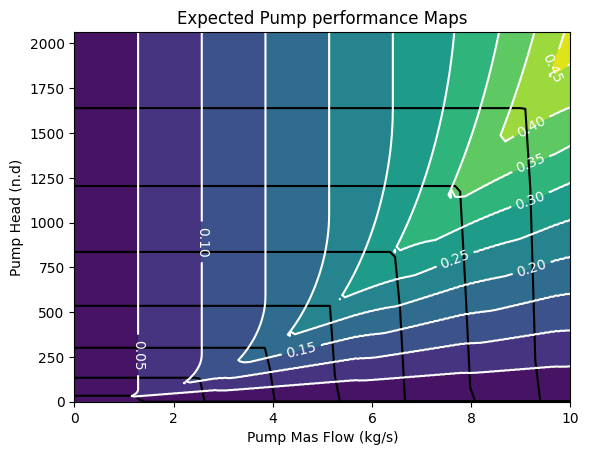

In [10]:
fig.set_size_inches(18.5, 10.5)
plt.contour(m_dot, dp, N, colors="k")
plt.ylabel("Pump Head (n.d)")
plt.xlabel("Pump Mas Flow (kg/s)")
plt.title("Expected Pump performance Maps")
k = plt.contourf(m_dot, dp, eta, levels =10)

k2 = plt.contour(m_dot, dp, eta, colors="white", levels=10)


plt.clabel(k2, k2.levels)

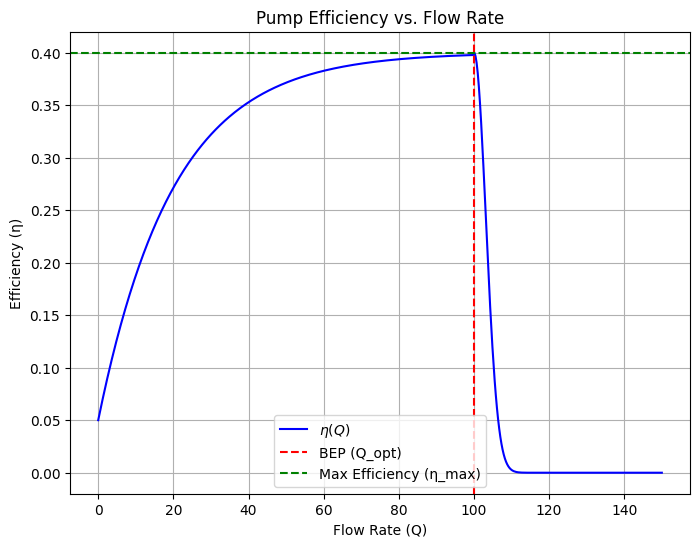

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the pump efficiency model
eta_min = 0.05  # Minimum efficiency at low flow rates
eta_max = 0.40  # Maximum efficiency at BEP
Q_min = 0  # Starting flow rate
Q_opt = 100  # Best Efficiency Point (BEP) flow rate
b = 0.05  # Shape parameter for the slow rise

# Define the flow rate range
Q = np.linspace(Q_min, 150, 500)

# Efficiency model with slow rise and rapid drop-off
eta = eta_min + (eta_max - eta_min) * (1 - np.exp(-b * (Q - Q_min)))
eta[Q > Q_opt] = eta_max * np.exp(
    -0.05 * (Q[Q > Q_opt] - Q_opt) ** 2
)  # Rapid drop-off past BEP

# Plotting the efficiency curve
plt.figure(figsize=(8, 6))
plt.plot(Q, eta, label=r"$\eta(Q)$", color="b")
plt.axvline(x=Q_opt, color="r", linestyle="--", label="BEP (Q_opt)")
plt.axhline(y=eta_max, color="g", linestyle="--", label="Max Efficiency (η_max)")
plt.xlabel("Flow Rate (Q)")
plt.ylabel("Efficiency (η)")
plt.title("Pump Efficiency vs. Flow Rate")
plt.legend()
plt.grid(True)
plt.show()

## 5 - Turbopump Characteristics

First thing we need to do is intantiate and size all of our key objects we use in the analysis

In [12]:
%%render param

rho_ox = 786  # kg/m**3
rho_fu = 788 # kg/m**3

<IPython.core.display.Latex object>

### 3.1 - Gas Generator Sizing

The gas generator has the following sizing:

In [13]:
%%render param sci_not

Pcc = 25e5 # Pa
MR_nom = 1
eta_c = 0.85
m_dot_t = 38.655e-3 # kg/s


<IPython.core.display.Latex object>

**Injector Parameters**

Fuel Side:

In [14]:
%%render param sci_not

Pf_inlet = 50e5 # Pa
rho_f_inlet = 786 # kg/s
Cd_f = 0.4

<IPython.core.display.Latex object>

Oxidiser Side:

In [15]:
%%render param sci_not

Po_inlet = 50e5 # Pa
rho_o_inlet = CP.PropsSI("D", "P", Po_inlet, "Q", 0, "NitrousOxide") # kg/s
Cd_o = 0.5

<IPython.core.display.Latex object>

We then define our classes for the gas generator

In [16]:
Nitrous = IncompressibleFluid(rho=rho_o_inlet, P=Po_inlet)
IPA = IncompressibleFluid(rho=rho_f_inlet, P=Pf_inlet)

GG = GasGenerator(
    Ox="N2O", Fu="C3H8O,2propanol", Pcc=Pcc, MR=MR_nom)  # , look_up_file="combustion_date.csv"

GG.comb_object(
    look_up=True, combustion_file="n2o_ipa.yaml" , look_up_file="combustion_date.csv")

In [17]:
GG.get_c_star(Pcc=10e5, MR=1, eta_c=1)

array([1056.91602998])

In [18]:
GG.injector_cond(ox_in=Nitrous, fu_in=IPA, cdo=Cd_o, cdf=Cd_f)

GG.size_system(m_dot=m_dot_t, eta_c=eta_c)

{'P_cc': 2500000.0,
 'MR': np.float64(1.0),
 'T_o': array([1165.27509515]),
 'Cp': array([2004.43851349]),
 'gamma': array([1.30368399]),
 'R': array([460.44692093]),
 'ox_stiffness': 1.0,
 'fu_stiffness': 1.0,
 'm_dot_t': array([0.038655]),
 'm_dot_o': array([0.0193275]),
 'm_dot_f': array([0.0193275])}

### 3.2 - Pump Sizing

Pump is also sized normally as follows:

In [72]:
pump = Pump(D_1 = 20e-3,
            D_2 = 50e-3,
            D_3 = 50e-3)

pump.set_performance(C_c = 1.0,
                     psi = 0.2,
                     eta_bep = 0.293,
                     N_nom = 24e3 * 2 * np.pi/60)

### 3.3 - Turbine Sizing

The turbine is sized as follows:

In [73]:
turbine = Turbine(a_rat = 4.11,
                  D_m = 0.05, 
                  eta_nom = 0.1,
                  u_co_nom = 0.13)

### 3.4 - Turbopump Characteristic Map Generation

We can now instantiate our turbopump map based on our individual objects we have created

In [74]:
characteristic = TurboCharacteristics(pump = pump,
                                      turbine = turbine,
                                      gas_generator = GG)

We can then create a mesh grid of inlet pressures and mass flow rates to resolve for the system conditions accordingly.

In [75]:
k = 30

p_in_array = np.linspace(20, 50, k) * 1e5 # Pa
m_dot_array = np.linspace(10,500, k) * 1e-3 # kg/s

p_in_array, m_dot_array = np.meshgrid(p_in_array, m_dot_array)

Practice Run

In [ ]:
N_array = np.zeros([k, k])
Pw_array = np.zeros([k, k])
eta_array = np.zeros([k, k])

P_exit_array = np.zeros([k, k])
P_gg_inlet_array = np.zeros([k,k])

m_dot_gg_array = np.zeros([k, k])
T_gg_array = np.zeros([k, k])
MR_array = np.zeros([k, k])
P_gg_array = np.zeros([k, k])

error_array = np.zeros([k, k])


for index, x in np.ndenumerate(p_in_array):
    p = p_in_array[index]
    m_dot = m_dot_array[index]

    IPA.set_pressure(P=p)

    result = characteristic.solve_condition(
        fu_inlet=IPA, ox_inlet=Nitrous, m_dot_t=m_dot
    )

    N_array[index] = result["N"]
    Pw_array[index] = result["Power"]

    P_exit_array[index] = result["pump_exit"].get_pressure()
    P_gg_inlet_array[index] = result["gg_fuel_inlet"].get_pressure()

    m_dot_gg_array[index] = result["m_dot_t"]
    T_gg_array[index] = result["T_o"]
    MR_array[index] = result["m_dot_o"] / result["m_dot_f"]

    P_gg_array[index] = result["P_cc"]

    error_array[index] = result["error"]

    eta_array[index] = result["eta"]
    nk = result["N"]*60/(2*np.pi)

    print("*" *100)
    print(f"\nN: {nk}")
    print(f"Done: {index}")
    print("*" *100)

We can at long last create our contour plot!

Text(0.5, 1.0, 'Turbopump Shaft Speed')

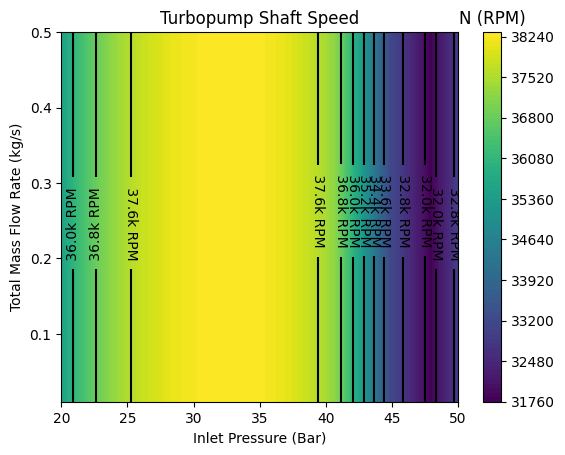

In [50]:
cs = plt.contourf(p_in_array/1e5, m_dot_array, N_array*60/(2*np.pi), levels=100)

cs2 = plt.contour(
    p_in_array / 1e5, m_dot_array, N_array * 60 / (2 * np.pi), levels=8, colors="k"
)

def formatter(input):
    return f" {input/1e3:.1f}k RPM "

cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title("N (RPM)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Turbopump Shaft Speed")

Text(0.5, 1.0, 'Turbopump Delivery Pressure')

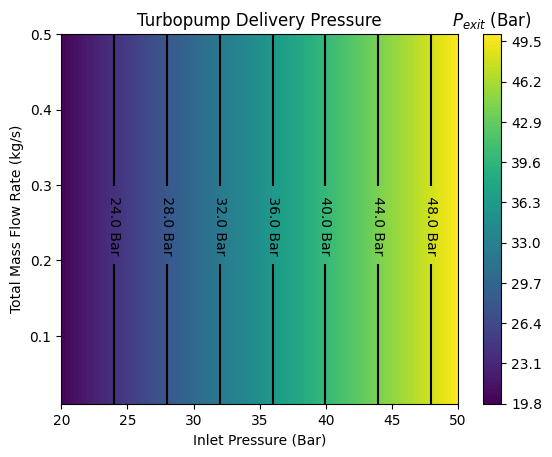

In [51]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, P_exit_array/1e5, levels=100)

cs2 = plt.contour(
    p_in_array / 1e5, m_dot_array, P_exit_array / 1e5, levels=8, colors="k"
)


def formatter(input):
    return f" {input:.1f} Bar "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$P_{exit}$ (Bar)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Turbopump Delivery Pressure")

Text(0.5, 1.0, 'Gas Generator Combustion Temperature')

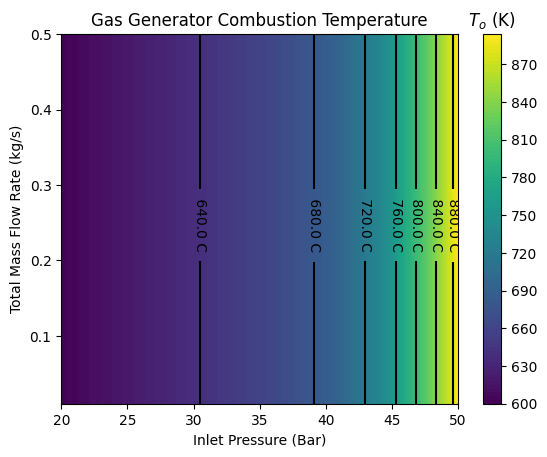

In [52]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, T_gg_array - 273.15, levels=100)

cs2 = plt.contour(
    p_in_array / 1e5, m_dot_array, T_gg_array - 273.15, levels=8, colors="k"
)


def formatter(input):
    return f" {input:.1f} C "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)


cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$T_o$ (K)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Combustion Temperature")

Text(0.5, 1.0, 'Gas Generator Mixture Ratio')

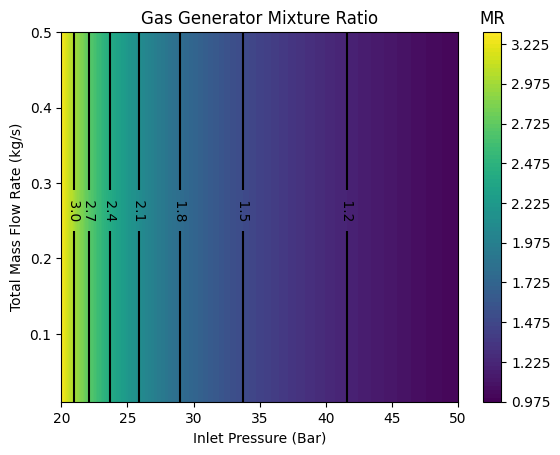

In [53]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, MR_array, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, MR_array, levels=8, colors="k")


def formatter(input):
    return f" {input:.1f} "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"MR")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Mixture Ratio")

Text(0.5, 1.0, 'Gas Generator Chamber Pressure')

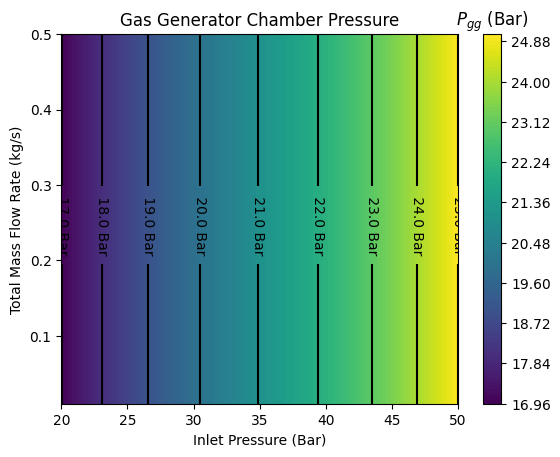

In [54]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, P_gg_array / 1e5, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, P_gg_array / 1e5, levels=8, colors="k")


def formatter(input):
    return f" {input:.1f} Bar "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$P_{gg}$ (Bar)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Chamber Pressure")

Text(0.5, 1.0, 'Gas Generator Mass Flow Rate')

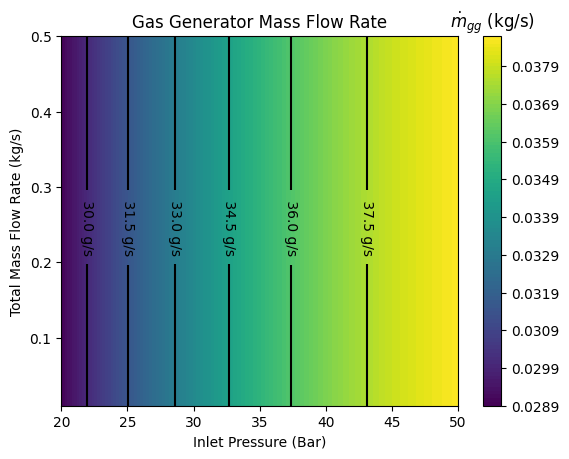

In [55]:

cs = plt.contourf(p_in_array / 1e5, m_dot_array, m_dot_gg_array, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, m_dot_gg_array, levels=8, colors="k")


def formatter(input):
    return f" {input*1e3:.1f} g/s "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$\dot{m}_{gg}$ (kg/s)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Mass Flow Rate")

Text(0.5, 1.0, 'Gas Generator Mass Flow Rate')

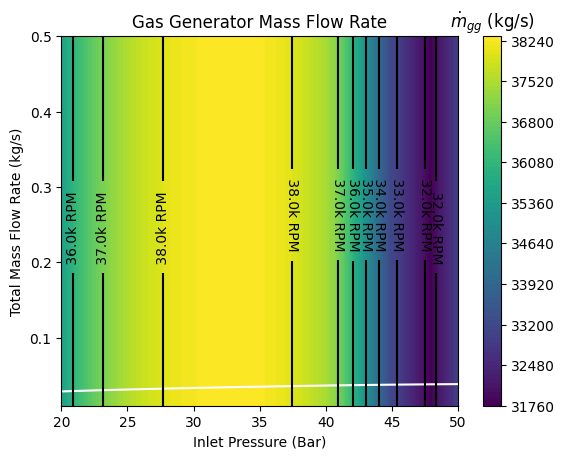

In [56]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, N_array * 60 / (2 * np.pi), levels=100)

cs3 = plt.contour(p_in_array / 1e5, m_dot_array, m_dot_array - m_dot_gg_array, levels=[0], colors="w")

cs2 = plt.contour(
    p_in_array / 1e5, m_dot_array, N_array * 60 / (2 * np.pi), levels=7, colors="k"
)

def formatter(input):
    return f" {input/1e3:.1f}k RPM "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$\dot{m}_{gg}$ (kg/s)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Mass Flow Rate")

Text(0.5, 1.0, 'Overall Cycle Efficiency')

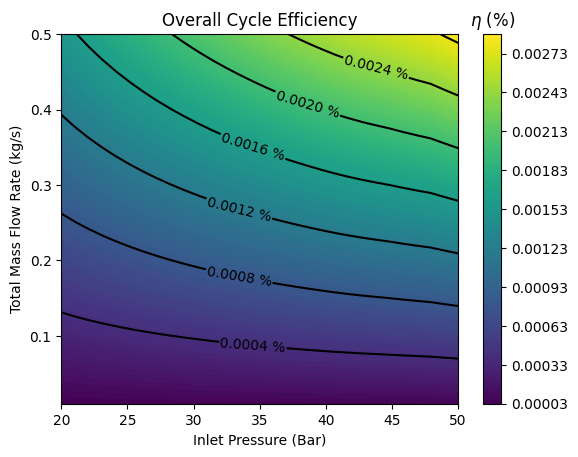

In [59]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, eta_array * 1e2, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, eta_array * 1e2, levels=8, colors="k")


def formatter(input):
    return f" {input:.4f} % "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$\eta$ (%)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Overall Cycle Efficiency")

Text(0.5, 1.0, 'Cycle Power')

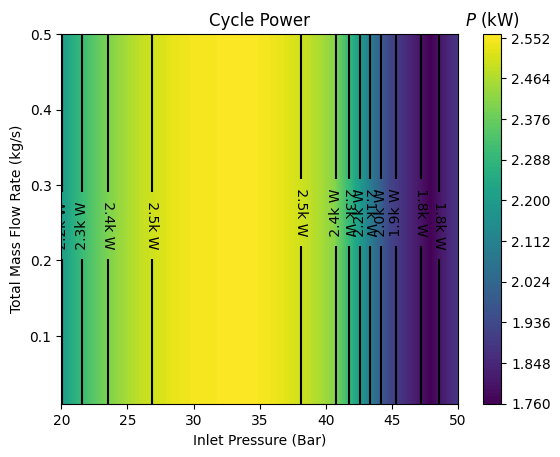

In [60]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, Pw_array/1e3, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, Pw_array/1e3, levels=8, colors="k")


def formatter(input):
    return f" {input:.1f}k W "


cs2.clabel(levels=cs2.levels, inline="True", fmt=formatter)

cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$P$ (kW)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Cycle Power")

Text(0.5, 1.0, 'Gas Generator Mass Flow Rate')

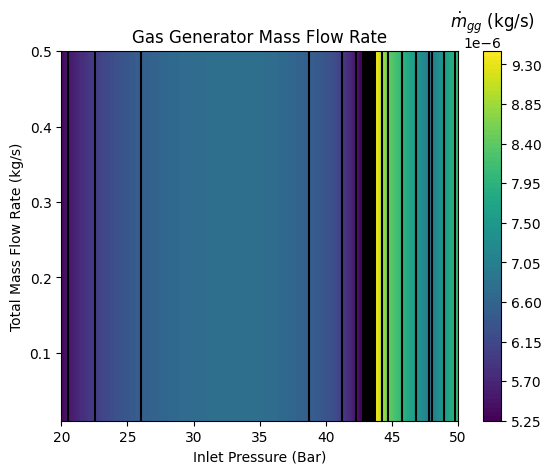

In [61]:
cs = plt.contourf(p_in_array / 1e5, m_dot_array, error_array, levels=100)

cs2 = plt.contour(p_in_array / 1e5, m_dot_array, error_array, levels=8, colors="k")


cbar = plt.colorbar(cs)
cbar.ax.set_title(r"$\dot{m}_{gg}$ (kg/s)")

plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Total Mass Flow Rate (kg/s)")
plt.title("Gas Generator Mass Flow Rate")

We can now make inverted plots describing how the system would fair under different engine propellant draws.

Text(0.5, 1.0, 'Turbopump Shaft Speed')

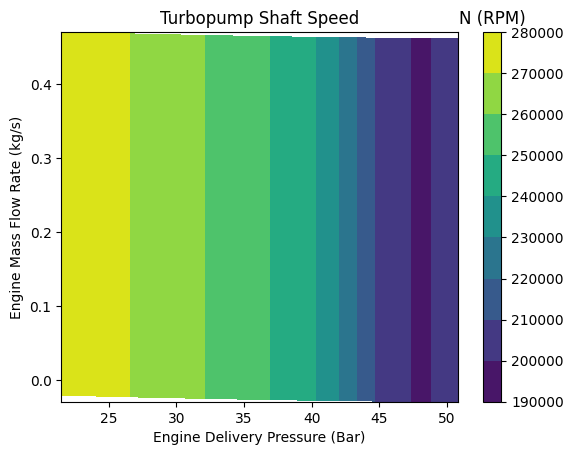

In [34]:
cs = plt.contourf(P_exit_array / 1e5, m_dot_array - m_dot_gg_array, N_array * 60 / (2 * np.pi))

cbar = plt.colorbar(cs)
cbar.ax.set_title("N (RPM)")

plt.xlabel("Engine Delivery Pressure (Bar)")
plt.ylabel("Engine Mass Flow Rate (kg/s)")
plt.title("Turbopump Shaft Speed")

We can go on to overlay our limits in terms of MR and combustion temperature

C:\Users\elias\AppData\Local\Temp\ipykernel_10096\3735672042.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  ax1 = plt.contour(
C:\Users\elias\AppData\Local\Temp\ipykernel_10096\3735672042.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  ax2 = plt.contour(
C:\Users\elias\AppData\Local\Temp\ipykernel_10096\3735672042.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  ax3 = plt.contour(
C:\Users\elias\AppData\Local\Temp\ipykernel_10096\3735672042.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Turbopump Shaft Speed')

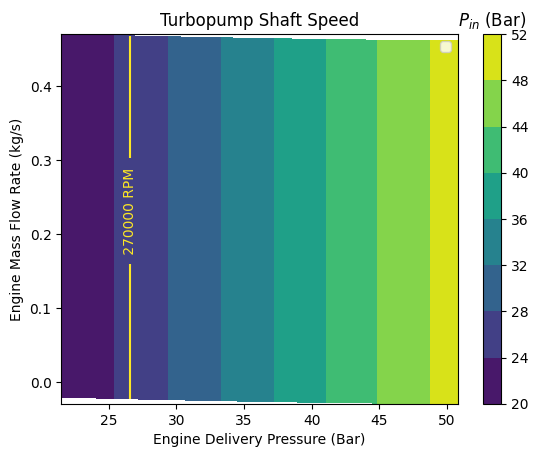

In [35]:
ax0 = plt.contourf(
    P_exit_array / 1e5,
    m_dot_array - m_dot_gg_array,
    p_in_array/1e5
)

ax1 = plt.contour(
    P_exit_array / 1e5, m_dot_array - m_dot_gg_array, N_array * 60 / (2 * np.pi), levels=[21e3, 27e4], label="Rotor Dynamic Modes"
)

ax1.clabel(levels=ax1.levels, inline="True", fmt=f" %d RPM ")

ax2 = plt.contour(
    P_exit_array / 1e5, m_dot_array - m_dot_gg_array, MR_array, levels=[0.8], label="MR Flame Holding Limit"
)

ax2.clabel(levels=ax2.levels, inline="True", fmt=f" %.2f MR ")

ax3 = plt.contour(
    P_exit_array / 1e5, m_dot_array - m_dot_gg_array, T_gg_array - 273.15, levels=[600], label="Thermal Limit"
)

ax3.clabel(levels=ax3.levels, inline="True", fmt=f" %.2f C ")

cbar = plt.colorbar(ax0)
cbar.ax.set_title("$P_{in}$ (Bar)")

plt.legend()

plt.xlabel("Engine Delivery Pressure (Bar)")
plt.ylabel("Engine Mass Flow Rate (kg/s)")
plt.title("Turbopump Shaft Speed")

### 3.5 - Monte Carlo Analysis

In the Turbomachinery design, there are many uknow